<a href="https://colab.research.google.com/github/UsikaDesu/Capstone-Project-Mood-Detection/blob/main/Classics_Mood_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/FER-2013.zip'

extract_path = '/content/extracted_images'

os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Zip file extracted.')


Zip file extracted.


In [ ]:
import numpy as np
from PIL import Image

In [ ]:
def load_images_from_folder(folder, label_map):
    images = []
    labels = []
    for root, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                img = img.convert('RGB')
                img_array = np.array(img)
                images.append(img_array)

            # Extract the label from the folder structure
            label_name = os.path.basename(root)
            if label_name in label_map:
                label = label_map[label_name]
                labels.append(label)
            else:
                print(f"Warning: {label_name} not in label map.")

    return images, labels


In [ ]:
# Define the label map (assuming you have 7 labels)
label_map = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Load images and labels
image_dir = extract_path + '/train'
images, labels = load_images_from_folder(image_dir, label_map)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Save the numpy arrays to .npy files
np.save('/content/drive/My Drive/images.npy', images)
np.save('/content/drive/My Drive/labels.npy', labels)

print('Images and labels saved to .npy files.')

Images and labels saved to .npy files.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras import layers
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import resize

import h5py

In [ ]:
image=np.load('/content/drive/MyDrive/images.npy')

In [ ]:
labels=np.load('/content/drive/MyDrive/labels.npy')

0

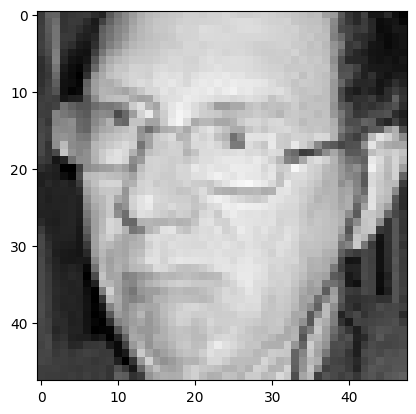

In [ ]:
plt.imshow(image[5])
labels[5]

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the entire dataset
data = np.load('/content/drive/My Drive/images.npy')
labels = np.load('/content/drive/My Drive/labels.npy')

# First split: split data into train+val and test sets
x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Second split: split x_temp and y_temp into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print shapes to verify
print(f'Training data shape: {x_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')

# Save the splits as .npy files
np.save('/content/drive/My Drive/x_train.npy', x_train)
np.save('/content/drive/My Drive/y_train.npy', y_train)
np.save('/content/drive/My Drive/x_val.npy', x_val)
np.save('/content/drive/My Drive/y_val.npy', y_val)
np.save('/content/drive/My Drive/x_test.npy', x_test)
np.save('/content/drive/My Drive/y_test.npy', y_test)

print('Training, validation, and test data and labels saved as .npy files.')


Training data shape: (17225, 48, 48, 3)
Training labels shape: (17225,)
Validation data shape: (5742, 48, 48, 3)
Validation labels shape: (5742,)
Test data shape: (5742, 48, 48, 3)
Test labels shape: (5742,)
Training, validation, and test data and labels saved as .npy files.


In [ ]:
x_val=np.load('/content/drive/MyDrive/x_val.npy')

In [ ]:
y_val=np.load('/content/drive/MyDrive/y_val.npy')

0

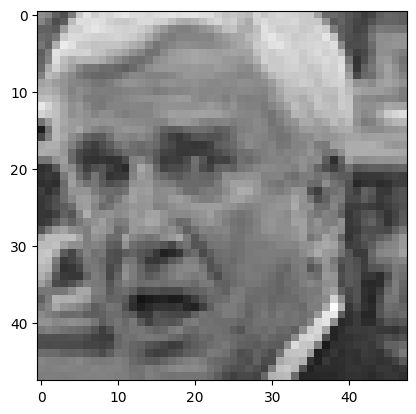

In [ ]:
plt.imshow(x_val[15])
y_val[15]

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, verbose=1, restore_best_weights=True, min_delta=0.01,
                              baseline=0.6)

In [ ]:
# Example adjustments to model architecture and training process

# Ensure classes are balanced
from collections import Counter
print(Counter(y_train))

# Increase model complexity
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

num_classes = 7
input_shape = (48, 48, 3)

input_layer = Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Train the model with augmented data
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=80,
    validation_data=val_generator,
    validation_steps=len(x_val) // 32,
    callbacks=[early_stopping]
)

Counter({3: 4341, 4: 2981, 5: 2900, 2: 2499, 0: 2391, 6: 1844, 1: 269})


Epoch 1/80


<ipython-input-15-3a3df83182c6>:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


538/538 [==============================] - 342s 633ms/step - loss: 1.8209 - accuracy: 0.2437 - val_loss: 1.8116 - val_accuracy: 0.2510
Epoch 2/80
538/538 [==============================] - 336s 624ms/step - loss: 1.8021 - accuracy: 0.2530 - val_loss: 1.7829 - val_accuracy: 0.2638
Epoch 3/80
374/538 [===================>..........] - ETA: 1:34 - loss: 1.7925 - accuracy: 0.2541

KeyboardInterrupt: 

180/180 [==============================] - 1s 3ms/step
Accuracy: 53.13%
Confusion Matrix
[[ 359    0   30   76  169  116   29]
 [  47    0    4    7   19   14    7]
 [ 127    0   73   60  217  146  145]
 [  57    0   21 1141  112   61   39]
 [  62    0   29  106  658  144   21]
 [ 137    0   29  106  328  357   20]
 [  31    0   49   53   61   12  463]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.44      0.46      0.45       779
     Disgust       0.00      0.00      0.00        98
        Fear       0.31      0.10      0.15       768
       Happy       0.74      0.80      0.77      1431
         Sad       0.42      0.65      0.51      1020
    Surprise       0.42      0.37      0.39       977
     Neutral       0.64      0.69      0.66       669

    accuracy                           0.53      5742
   macro avg       0.42      0.44      0.42      5742
weighted avg       0.51      0.53      0.51      5742



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


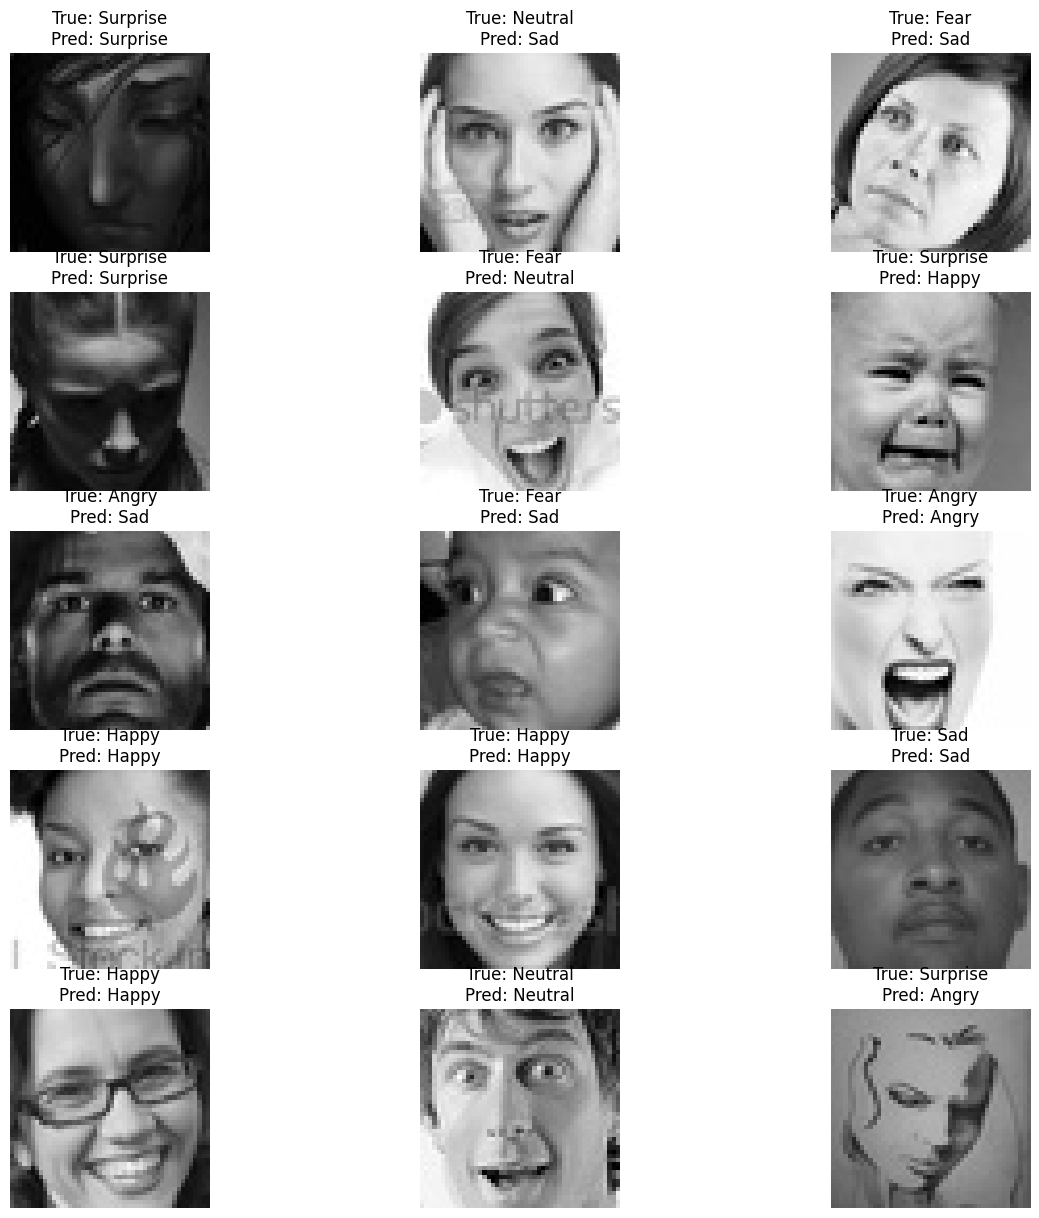

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the test dataset and labels
x_test = np.load('/content/drive/My Drive/x_test.npy')
y_test = np.load('/content/drive/My Drive/y_test.npy')

# Normalize the test data
x_test = x_test.astype('float32') / 255

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix')
print(cm)

# Classification report
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
cr = classification_report(y_test, y_pred_classes, target_names=target_names)
print('Classification Report')
print(cr)

In [ ]:
# Visualize the images with their predicted and true labels
def visualize_predictions(images, true_labels, pred_labels, class_names, num_images=15):
    plt.figure(figsize=(15, 15))
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 3, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a random subset of the test set predictions
visualize_predictions(x_test, y_test, y_pred_classes, target_names, num_images=15)


In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 692.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
    

In [ ]:
import os

# Ensure the uploaded model file is named 'model.h5'
model_path = 'model.h5'
output_dir = 'model_json'

# Create the output directory
os.makedirs(output_dir, exist_ok=True)

# Run the tensorflowjs_converter command
!tensorflowjs_converter --input_format keras {model_path} {output_dir}


2024-06-20 13:04:00.527423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 13:04:02.080391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# List the files in the output directory
!ls {output_dir}


group1-shard1of5.bin  group1-shard3of5.bin  group1-shard5of5.bin
group1-shard2of5.bin  group1-shard4of5.bin  model.json
